# Lab-3: Logistic Regression
_____
##### In this lab, you will apply Logistic Regression to predict survival on Titanic and learn to analyze classification results.

### Objectives:
1. Visualize LogReg basics
2. Split unbalanced data
3. Apply Logistic regression
4. Analyze results (Confusion Matrix, Precision, Recall)
-----

### Concepts Visualization

Here are main equations behind Logistic Regression:

$\hat p(x) = \frac{e^{\beta_0 + \beta_1 x}}{1+e^{\beta_0 + \beta_1 x}}$

$L(\hat{p}(x_i), y_i) = -y_i\log (\hat{p}(x_i)) - (1 - y)_i\log (1 -\hat{p}(x_i))$

$L(\hat{p}(x_i), y_i) = \left\{\begin{matrix}
\ - log (\hat{p}(x_i)), & y_i=1\\ 
\ - log (1 -\hat{p}(x_i)), & y_i=0
\end{matrix}\right.$

$\hat y = \left\{\begin{matrix}
1 && \hat p(x) > threshold\\ 
0 && otherwise 
\end{matrix}\right.$


<br>

1. What problem does Logistic Regression solve? Binary classification problems, but it can be extended to solve multiple classification problems.
2. What is the output of Logistic Regression model? The value of sigmoid function $\hat p(x)$.
2. Why can't we use average MSE as a loss function (as we did in Linear Regression)? The function is not convex, that's why we cannot use gradient descent.
3. How can we adapt Logistic Regression to solve a multiclass problem? One-vs-All, One-vs-One

<br>
Let's now see how the shape of $\hat p(x)$ depends on its parameters:

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

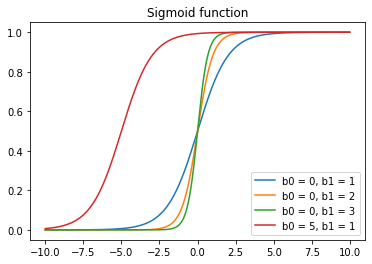

In [38]:
x = np.arange(-10, 10, 0.01)

def plot(b0, b1):
    p = np.exp(b0 + b1 * x) / (1 + np.exp(b0 + b1 * x))
    # preds = np.where(p > 0.5, 1, 0)
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)
    # plt.plot(x, (preds - p)**2, label=label)

plot(0,1)
plot(0,2)
plot(0,3)
plot(5,1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

What is controlled by parameters b0, b1? b0-When the sigmoid starts to grow and b1-how fast the function grows.
<br><br> 
Let's now visualize the components of the Loss function:

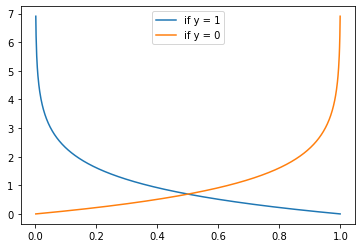

In [39]:
x = np.arange(0.001, 1, 0.001)
y1 = -np.log(x)
y0 = -np.log(1-x)

plt.plot(x,y1, label="if y = 1")
plt.plot(x,y0, label="if y = 0")
plt.legend()
plt.show()

What are the benefits of using logarithms in the loss function?   <br><br>

### Loading Data

In [40]:
import pandas as pd
data = pd.read_csv('data/titanic.csv')
data

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,151.5500,S
2,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,151.5500,S
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,151.5500,S
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,151.5500,S
...,...,...,...,...,...,...,...,...,...
1304,0,3,"Zabour, Miss. Hileni",female,14.50,1,0,14.4542,C
1305,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,C
1306,0,3,"Zakarian, Mr. Mapriededer",male,26.50,0,0,7.2250,C
1307,0,3,"Zakarian, Mr. Ortin",male,27.00,0,0,7.2250,C


In [41]:
# removing name column
data = data.drop(['name'], axis = 1)

What do we know about the output class distribution? What percentage of people had survived? Is it important to have the same distribution in test and train sets? Why?

##### Task. Find and print the proporion of the positive (survived) class in the dataset, then split data to train and test sets preserving that proportion. Finally, as a check, calculate and print proportions in resulting sets.

In [42]:
from sklearn.model_selection import train_test_split

X, y = data.loc[:, 'pclass':], data['survived']
# find and print the proportion of positive samples in data
print('% of positive samples in whole data:', sum(y == 1) / len(y) * 100)

# split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.38, stratify=y)

# find and print the proportion of positive samples in train and test sets, make sure they are approx same
print('% of positive samples in train set:', sum(y_train == 1) / len(y_train) * 100)
print('% of positive samples in test set:', sum(y_test == 1) / len(y_test) * 100)

% of positive samples in whole data: 38.19709702062643
% of positive samples in train set: 38.224414303329226
% of positive samples in test set: 38.152610441767074


#### Data preprocessing

... is done for you! But you are free to change it if needed.

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# imputing missing values
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(x_train)
x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# one-hot-encode categorical features
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['sex', 'embarked']
encoder.fit(x_train[f_names])
x_train = ohe_new_features(x_train, f_names, encoder)
x_test = ohe_new_features(x_test, f_names, encoder)

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [44]:
x_train

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,0.0,0.485377,0.125,0.166667,0.162314,0.0,0.0,0.0
1,0.5,0.623447,0.000,0.000000,0.020495,0.0,0.0,1.0
2,1.0,0.447722,0.125,0.000000,0.033963,0.0,0.0,1.0
3,1.0,0.271997,0.000,0.000000,0.015412,1.0,0.0,1.0
4,1.0,0.786620,0.000,0.000000,0.018714,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
806,0.5,0.447722,0.000,0.000000,0.025374,1.0,0.0,1.0
807,1.0,0.234342,0.000,0.000000,0.028302,1.0,0.0,1.0
808,1.0,0.033513,0.375,0.166667,0.041136,0.0,0.0,1.0
809,1.0,0.221790,0.000,0.000000,0.015216,1.0,0.0,1.0


### Logistic Regression

Now we are ready to see Logistic Regression in practice. 

#### Task. Fit Logistic Regression and output Accuracy, Precision, and Recall scores on test set.
$f1score = (2 * recall * precision) / (recall + precision)$

$recall = TP / (TP + FN)$

$precision = TP / (TP + FP)$

When the model is pessimistic - high precision, low recall.

When the model is optimistic - low precision, high recall.

When the dataset is imbalanced:
1. it's better to use metrics that aren't biased towards the majority class, such as precision, recall and f1-score.
2. use oversampling or undersampling.
3. move the threshhold of the classification to classify the minority class easier.
4. increase class weights of the minority class.

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

# caclulate and print metrics
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f'Precision: {metrics.precision_score(y_test, y_pred)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred)}')

Accuracy: 0.5883534136546185
Precision: 0.2413793103448276
Recall: 0.03684210526315789
F1-score: 0.0639269406392694


What about Logistic Regression Coefficients? Can we interpret them?

In [46]:
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

('pclass', -1.526451655411288)
('age', -2.012330947113824)
('sibsp', -1.7166967266787374)
('parch', -0.15414302838165198)
('fare', 0.08463214208976616)
('sex_male', -2.4986361751946466)
('embarked_Q', -0.5096808477033761)
('embarked_S', -0.6887559268707096)


How can we choose a threshold? Let's try different ones and see their effect on metrics.

#### Task. Calculate Accuracy, Precision, and Recall values for each of the given threshold values and plot them.

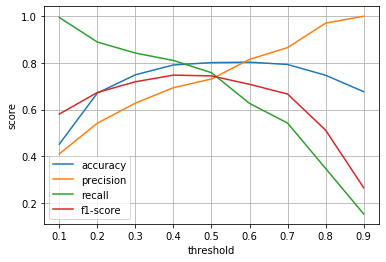

In [30]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# calculate metrics for each threshold above and plot the result as below.
y_pred_proba = clf.predict_proba(x_test)[:, 1]

results = [[],[],[],[]]

for i in thresholds:
    y_pred = np.where(y_pred_proba > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_pred))
    results[1].append(metrics.precision_score(y_test, y_pred))
    results[2].append(metrics.recall_score(y_test, y_pred))
    results[3].append(metrics.f1_score(y_test, y_pred))
    
    
plt.plot(thresholds, results[0], label='accuracy')
plt.plot(thresholds, results[1], label='precision')
plt.plot(thresholds, results[2], label='recall')
plt.plot(thresholds, results[3], label='f1-score')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

### Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? 

<table><tr><td><img src='https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png'></td><td><img src='http://wiki.fast.ai/images/6/61/Confusion_matrix.png' style='width: 400px;'></td></tr></table>

<img align='center' src='https://www.researchgate.net/profile/Emanuele_Principi/publication/324226324/figure/fig2/AS:612091408941056@1522945372985/Normalized-confusion-matrix-of-best-performing-models-on-devel-subset-a-SVM.png' style='width: 350px;'>


In [47]:
titanic_true_labels = np.array(y_test)
titanic_pred_labels = y_test_pred

In [48]:
sample_true_labels = np.array([2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 0])
sample_pred_labels = np.array([2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2])

#### Task. You need to fill in the function which builds a Confusion Matrix based on true and predicted labels. Your solution should be generalizable to any number of classes. You can assume that classes are represented as numbers (0,1,2,3,...)

In [49]:
def calc_confusion_matrix(true_labels, pred_labels):
    # Calculate a confusion matrix: 
    # True labels along Y axis, Predicted ones along X axis
    num_uniques = len(np.unique(true_labels))
    cm = np.zeros(shape=(num_uniques, num_uniques))
    
    for true_label, pred_label in zip(true_labels, pred_labels):
        cm[true_label][pred_label] += 1
        
    return cm

titanic_cm = calc_confusion_matrix(titanic_true_labels, titanic_pred_labels)
sample_cm = calc_confusion_matrix(sample_true_labels, sample_pred_labels)
print('Confusion Matrix for Titanic:\n', titanic_cm, '\n')
print('Confusion Matrix for Sample set:\n', sample_cm)

Confusion Matrix for Titanic:
 [[254.  54.]
 [ 56. 134.]] 

Confusion Matrix for Sample set:
 [[4. 1. 2.]
 [3. 0. 2.]
 [1. 2. 1.]]


In [50]:
# Run this block of code to see what your result should look like
from sklearn.metrics import confusion_matrix
print('TRUE Confusion Matrix for Titanic:\n', confusion_matrix(titanic_true_labels, titanic_pred_labels), '\n')
print('TRUE Confusion Matrix for Sample set:\n', confusion_matrix(sample_true_labels, sample_pred_labels))

TRUE Confusion Matrix for Titanic:
 [[254  54]
 [ 56 134]] 

TRUE Confusion Matrix for Sample set:
 [[4 1 2]
 [3 0 2]
 [1 2 1]]
